https://www.kaggle.com/headsortails/pytanic

## Outline:

1. [Load Data and Modules](#load)
1. [Initial Exploration](#explore)
1. [Relations between features](#relations)
1. [Missing values](#missing)
1. [Derived (engineered) features](#derived)
1. [Preparing for modelling](#encode)
1. [Modelling](#model)
1. [Preparing our prediction for submission](#submit)

## 1. Load Data and Modules

In [2]:
# %matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
import lightgbm as lgb
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

**Load input data.**
<br>
And combine the available features of train and test data sets.<br>
test of course doesn't have the column that indicates survival.

In [3]:
import os

os.listdir('../input')

['titanic']

In [4]:
DATA_PATH = '../input/titanic'

train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
combine = pd.concat([train.drop('Survived', 1), test])
# pd.concat() : 
# 기준 열(key column)을 사용하지 않고 단순히 데이터를 연결(concatenate)한다.
# 기본적으로 위/아래로 연결을 하며 옆으로 연결하고 싶다면 axis=1로 인수를 설정한다.

## 2. Initial Exploration

**Look at your data in as many different ways as possible.** 
<br>
Some properties and connections will be immediately obvious. Others will require you to examine the data, or parts of it, in more specific ways. Metaphorically speaking: this is the part where the detective finds the clues.

First a broad overview. What are the types of data and their typical shape and content?

In [5]:
train.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Together with the PassengerId which is just a running index and the indication whether this passenger survived (1) or not (0) we have the following information for each person:

- *Pclass* is the Ticket-class: first(1), second(2), and third(3) class tickets were used. This is an ordinal integer feature.

- *Name* is the name of passenger. The names also contain titles and some persons might share the same surname; indicating family relations. We know that some titles can indicate a certain age group. For instance *Master* is a boy while *Mr* is a man. This feature is a character string of variable length but similar format.

- *Sex* is an indicator whether the passenger was female or male. This is a categorical text string feature.

- *Age* is the integer age of passenger. There are NaN values in this column.

- *SibSp* is another ordinal integer features that gives the number of siblings or spouses traveling with each passenger.

- *Parch* is another ordinal integer features that gives the number of parents or children traveling with each passenger.

- *Ticket* is a character string of variable length that gives the ticket number.

- *Fare* is a float feature showing how much each passenger paid for their rather memorable journey.

- *Cabin* gives the cabin number of each passenger. There are NaN in this column. This is another string feature.

- *Embarked* shows the port of embarkation as a categorical character value.

In summary we have 1 floating point feature(*Fare*), 1 integer variable(*Age*), 3 ordinal integer features(*Pclass*, *SibSp*, *Parch*), 2 categorical text features(*Sex*, *Embarked*), and 3 text string features(*Ticket*, *Cabin*, *Name*).

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The minium/maxim values for pclass, age, sibsp, parch show us the range of these features. Also we see that there's quite a range in fares.

### *Missing values*

In [7]:
print(train.isnull().sum())
print(test.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


Knowing about missing values is import because they indicate how much we don't know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

**We learn:**

- In the **training data** a large majority of *Cabin* numbers are missing, together with 177 *Age* values and 2 *Embarked* values.

- Also, in the **test** data there is one *Fare* missing (cheeky selection), almost 100 *Age* values are unknown, and only 91 *Cabin* numbers were preserved. Best to keep that in mind.

In [8]:
surv = train[train['Survived'] == 1]
nosurv = train[train['Survived'] == 0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      % (len(surv), 1.*len(surv)/len(train)*100.0,\
         len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


In our training data set about 60% of the passengers didn't survive. By flat out predicting that everyone in the testing data set died we would get a 60% accuracy. Let's try to do better than that.

Here we also define a consistent colour scheme for the distinguishing between survived / not survived. This scheme will (soon) be used throughout this kernel.

OK, let's go through the features one by one to see what we find. Here we will see how the distributions of survivors and non-survivors compare. Personally, I like histograms for a first look at comparing two or more populations in case of scaled features. For categorical features we will use barplots plus standard deviation bars, to better judge the significance.

Median age survivors: 28.0, Median age non-survivers: 28.0


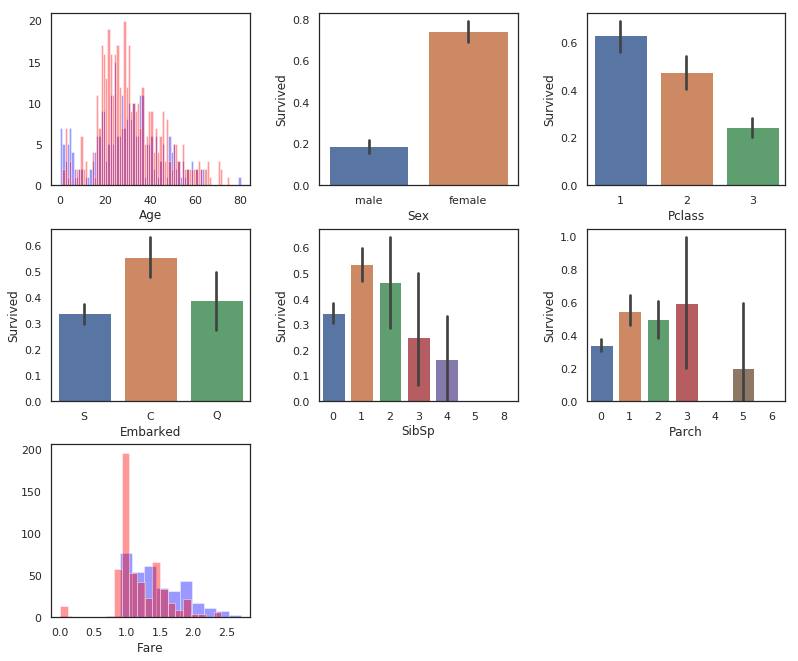

In [9]:
warnings.filterwarnings(action='ignore')

plt.figure(figsize=[12,10])
plt.subplot(331) # 3 rows 3 columns, 1 index
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col, axlabel='Age')
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col, axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
     % (np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

Above we are creating a kind of summary dashboard, where we collect relevant visualisations to study the distributions of the individual features. We use the matplotlib *subplot* tool to line up the individual plots in a grid. We use overlapping histograms for ordinal features and barplots for categorical features. The barplots show the fraction of peoplt (per group) who survived.
There's a lot going on in this figure, so take your time to look at all the details.

**We learn** the following things from studying the individual features:

- *Age* : The medians are identical. However, it's noticeable that fewer young adults have survived (ages 18 - 30-ish) whereas **children younger than 10-ish had a better survival rate.** Also, there are no obvious outliers that would indicate problem input data. The highest ages are well consistent with the overall distribution. There is a notable shortage of teenagers compared to the crowd of younger kids. But this could have natural reasons.

- *Pclass* : There's a clear trend that **being a 1st class passenger gives you better chances of survival.** Life just isn't fair.

- *SibSp & Parch* : **Having 1-3 siblings/spouses/parents/children on board (SibSp = 1-2, Parch = 1-3) suggests proportionally better survival numbers than being alone (SibSp + Parch = 0) or having a large family traveling with you.**

- *Embarked* : Well, that does look more interesting than expected. **Embarking at "C" resulted in a higher survival rate than embarking at "S".** There might be a correlation with other variables, here though.

- *Fare* : This is case where a linear scaling isn't of much help because there is a smaller number of more extreme numbers. A natural choice in this case is to trainsform the values logarithmically. For this to work we need to adjust for the zero-fare entries. The plot tells us that the **survival chances were much lower for the cheaper cabins.** Naively, one would assume that those cheap cabins were mostly located deeper inside the ship, i.e. further away from the life boats.

A little follow up: For *SibSp* we see in the plot that most of the differences are not very significant (overlapping error bars). Another way of checking the actual numbers are through *cross tables* :

In [10]:
tab = pd.crosstab(train['SibSp'], train['Survived'])
# pd.crosstab() 
# 범주형 변수로 되어있는 요인(factors)별로 교차분석(cross tabulations) 해서, 행, 열 요인 기준 별로 빈도를 세어서 도수분포표(frequency table), 교차표(contingency table)를 만들어주는
print(tab)

Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0


Passengers with more than 3 children+parents on board had low survival chances. However the corresponding number are not very large. For SibSp we have 15 vs 3, 5 vs 0, and 7 vs 0.

Random outccomes with 2 possibilities (like *heads or tails* when flipping a coin) follow the binomial distribution. We can use a *binomial test* to estimate the probability that 5 non-survivors out of a total 5 passengers with SibSp = 5 happened due to chance assuming the overall 38% survival chance for the entire sample.

In [11]:
stats.binom_test(x=5, n=5, p=0.62)

0.16417601599999998

Anything above 0.05 is usually not significant and therefore solely based on these numbers we cannot say whether the SibSp = 5 sample behaves different than the rest.

For larger numbers of Parch we have 4 vs 0, 4 vs 1, and 1 vs 0. Just by themselves, the last two are definitely not impressive. Combining them into parch >= 4 gives us 9 vs 1 which is much better.

**We learn:**

- Parch >= 4 and Sibsp >= 3 is bad. So is Parch + Sibsp = 0 (i.e. both 0). Parch in 1-3 and Sibsp in 1-2 is good.

### Cabin numbers

This is a tricky feature because there are so many missing values and the string don't all have the same number or formatting.

In [12]:
print("We know %i of %i Cabin numbers in the training data set and"
      % (len(train['Cabin'].dropna()), len(train)))
print("We know %i of %i Cabin numbers in the testing data set."
      % (len(test['Cabin'].dropna()), len(test)))
train.loc[:, ['Survived', 'Cabin']].dropna().head(8)

We know 204 of 891 Cabin numbers in the training data set and
We know 91 of 418 Cabin numbers in the testing data set.


,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27


**We can try out:**

- I suppose one could take the starting letters, which might indicate specific decks on the ship, and use them as an additional classifier. But for less than 25% of cabins known this might not be very useful. We'll see.

- Also, given that so few cabin numbers are know it doesn't seem than there are good records of them. Therefore, one should assume that it's more likely to know someone's cabin number if they survived. Let's see about that in the derived features.

*TODO: Why do some people have multiple cabin numbers? What does that mean?*

### Ticket numbers

That seems to be a hopeless variable at first because it just looks like random strings. But in these days, when you were traveling as a group/family did everyone really get their own ticket? Let's find out how many unique ticket numbers there are:

In [14]:
print("There are %i unique ticket numbers among the %i tickets."\
      % (train['Ticket'].nunique(), train['Ticket'].count()))

There are 681 unique ticket numbers among the 891 tickets.


Interesting. Sharing a ticket number is not uncommon. Let's follow that up a bit.

In [15]:
grouped = train.groupby('Ticket')
k = 0
for name, group in grouped:
    if (len(grouped.get_group(name)) > 1):
        print(group.loc[:, ['Survived', 'Name', 'Fare']])
        k += 1
    if (k > 10):
        break

     Survived                                               Name  Fare
257         1                               Cherry, Miss. Gladys  86.5
504         1                              Maioni, Miss. Roberta  86.5
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  86.5
     Survived                                    Name   Fare
262         0                       Taussig, Mr. Emil  79.65
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  79.65
585         1                     Taussig, Miss. Ruth  79.65
     Survived                            Name  Fare
110         0  Porter, Mr. Walter Chamberlain  52.0
475         0     Clifford, Mr. George Quincy  52.0
     Survived                                             Name     Fare
329         1                     Hippach, Miss. Jean Gertrude  57.9792
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  57.9792
     Survived                                    Name  Fare
166         1  Chibnall, Mrs. (Edith Mar

**We can try out:**

Working hypothesis: if your group (mostly family) survived then you survived as well, unless you were a man (and presumably helped your wife/daughter/lady friend). We could go through the trouble here to identify families by last name. However

1. Common last names might not be unique in the passenger list
2. As we see above a ticket is not always shared by people with a common name.

Therefore, a shared ticket might actually be a stronger predictor. Of course this assumption should be tested by doing the last-name thing too. In addition, we see that the *Fare* was identical for all the passengers in each ticket group. This is something we will explore in more detail below.